In [2]:
import pandas as pd
from itertools import chain
import numpy as np
import os
import matplotlib.pyplot as plt


In [3]:
def read_ar_harp_file(file):
    
    os.chdir('/home/xmcai8/Server_PIL_notebook/')
    df = pd.read_csv(file)

    df['AR_number'] = df['AR_number'].astype(int)
    df['len_harp'] = df['len_harp'].astype(int)
    
    df = df[df['len_harp']>0].copy()
    df['HARP_num_obj'] = df['HARP_num_obj'].apply(lambda x: [int(x)] if type(x) is not str else list(map(int, x.split(';'))))
    
    return df

In [4]:
def read_pil_csv(h):
    
    df = pd.read_csv('{}/{}_pil.csv'.format(h,h),index_col='Unnamed: 0',parse_dates=True)
    
    return df

In [5]:
#get noaa_file
def get_noaa_ar_df(file_path):
    
    os.chdir('/home/xmcai8/Server_PIL_notebook/')
    noaa_ar = pd.read_csv(file_path)
    noaa_ar = noaa_ar.rename(columns={'Unnamed: 0': 'id'})
    noaa_ar = noaa_ar.set_index("id")
    noaa_ar['year'] = noaa_ar['year'].astype(str)
    noaa_ar['month'] = noaa_ar['month'].astype(str)
    noaa_ar['day'] = noaa_ar['day'].astype(str)
    noaa_ar['ar_time'] = pd.to_datetime(noaa_ar[['year', 'month', 'day']].apply(lambda x: '-'.join(x), axis=1))
#     noaa_ar['Datetime_st_time'] = noaa_ar['ar_time'].apply(lambda row: row - dt.timedelta(hours = 12))
#     noaa_ar['Datetime_ed_time'] = noaa_ar['ar_time'].apply(lambda row: row + dt.timedelta(hours = 12))
    noaa_ar['longitude'] = noaa_ar['central_meridian_dist'].astype(float)
    noaa_ar['latitude'] = noaa_ar['latitude'].astype(float)
    
    
    df = noaa_ar[['ar_time','noaa_ar_no','longitude','latitude','corr_whole_spot_area','mcintosh','LL','number_of_spots','greenwich']]
    df = df.sort_values(by=['ar_time','noaa_ar_no']).reset_index(drop=True)
    
    df = df[df['ar_time'] >= np.datetime64('2010-05-01')].copy()
    
    
    
    return df

In [6]:
noaa_ar_df = get_noaa_ar_df('MU_noaa_ars_plages.csv')

In [7]:
def search_ar_pil_series(ar_df,ar_all):
    
    folder_path = '/data/MPIL/HMI_PIL/'
    
    os.chdir(folder_path)
    
    
    ar_pil = dict()
    
    for index,row in ar_df[ar_df['len_harp']>0].iterrows():
        
        if row['len_harp'] ==1:
            
            harp_num = row['HARP_num_obj'][0]
            
            try:
                
                pil_series = read_pil_csv(harp_num)
                
            
            except:
                
                print(row['AR_number'], "doesn't have HARP {} pil csv file".format(harp_num))
                
            
            else:
                
                ar_pil[(row['AR_number'],harp_num)] = pil_series
                
            
            
                
        
        
        else:
            
            ar_number = row['AR_number']
            
            ar_idx = list(ar_all[ar_all['noaa_ar_no']== ar_number]['ar_time'])
            
            harp_num1 = row['HARP_num_obj'][0]
            
            harp_num2 = row['HARP_num_obj'][1]
            
            
            try:
                
                pil_series1 = read_pil_csv(harp_num1)
                
            
            except:
                
                print(row['AR_number'], "doesn't have HARP {} pil csv file".format(harp_num1))
                
                
            else:    
                
                
                try: 
                
                    pil_series2 = read_pil_csv(harp_num2)
            
                except:
                
                    print(row['AR_number'], "doesn't have HARP {} pil csv file".format(harp_num2))
                
            
                else:
                # choose the HARP whose AR has more intersection with HARP

#                     if (pil_series2.index[-1] - pil_series2.index[0]) > (pil_series1.index[-1] - pil_series1.index[0]):
                    
#                         ar_pil[(row['AR_number'],harp_num2)] = pil_series2
                    
                    if sum(pil_series2.index.isin(ar_idx)) > sum(pil_series1.index.isin(ar_idx)):
            
                        ar_pil[(row['AR_number'],harp_num2)] = pil_series2
        

                    else:
                    
                        ar_pil[(row['AR_number'],harp_num1)] = pil_series1
                    
    
    
    
    return ar_pil
                
    


In [8]:
def avg_pil(dic,attr):
    
    avg_dict = dict()
    
    for key in dic:
        
        
        f = dic[key][dic[key]['detection_flag']!='no pil SPE'].copy()
        
        if len(f)>0:
        
            f.fillna(0,inplace=True)
            
            if key[1] not in avg_dict:
        
                avg_dict[key[1]]= f[attr].mean()
            
            else:
                
                print("Repeat HARP", key)
        
        else:
            
            print("All SPE HARP",key)
        
    
    return avg_dict
    
    
    
    

### New Eruptive List

In [9]:
er_ar_df = read_ar_harp_file('a_erup_ar_harp.csv')

In [10]:
er_ar_df

AR_number HARP_num  len_harp HARP_num_obj
290      11069      [8]         1          [8]
291      11079     [49]         1         [49]
292      11081     [54]         1         [54]
293      11093    [115]         1        [115]
294      11112    [211]         1        [211]
..         ...      ...       ...          ...
467      12665   [7075]         1       [7075]
468      12671   [7107]         1       [7107]
469      12672   [7110]         1       [7110]
470      12673   [7115]         1       [7115]
471      12685   [7169]         1       [7169]

[182 rows x 4 columns]

In [11]:
er_ar_dict = search_ar_pil_series(er_ar_df,noaa_ar_df)

#### * Number of PIL

In [12]:
"""
Repeat HARP (11162, 384)
Repeat HARP (11319, 940)
Repeat HARP (11348, 1028)
Repeat HARP (11402, 1321)
Repeat HARP (11430, 1449)
Repeat HARP (11885, 3321)
Repeat HARP (11944, 3563)
All SPE HARP (12087, 4225)
Repeat HARP (12173, 4580)
Repeat HARP (12345, 5541)
Repeat HARP (12567, 6670)
"""
er_avg_dict = avg_pil(er_ar_dict,'num_PILs')

Repeat HARP (11162, 384)
Repeat HARP (11319, 940)
Repeat HARP (11348, 1028)
Repeat HARP (11402, 1321)
Repeat HARP (11430, 1449)
Repeat HARP (11885, 3321)
Repeat HARP (11944, 3563)
All SPE HARP (12087, 4225)
Repeat HARP (12173, 4580)
Repeat HARP (12345, 5541)
Repeat HARP (12567, 6670)


In [13]:
len(er_avg_dict)

171

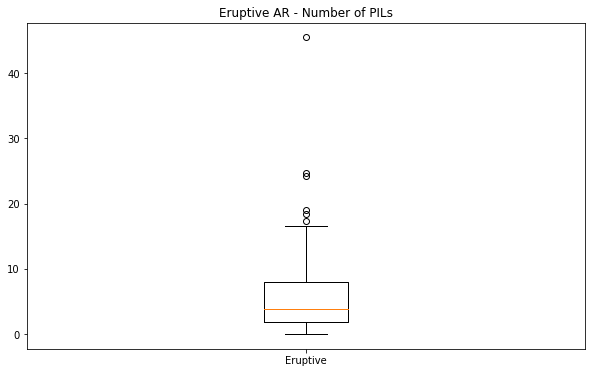

In [14]:
plt.figure(figsize=(10,6))
plt.title("Eruptive AR - Number of PILs")
plt.boxplot(list(er_avg_dict.values()))
plt.xticks([1], ["Eruptive"])
plt.show()

#### * Sum of PIL Size

In [15]:
er_avg_pil_size_dict = avg_pil(er_ar_dict,'sum_PIL_length')

Repeat HARP (11162, 384)
Repeat HARP (11319, 940)
Repeat HARP (11348, 1028)
Repeat HARP (11402, 1321)
Repeat HARP (11430, 1449)
Repeat HARP (11885, 3321)
Repeat HARP (11944, 3563)
All SPE HARP (12087, 4225)
Repeat HARP (12173, 4580)
Repeat HARP (12345, 5541)
Repeat HARP (12567, 6670)


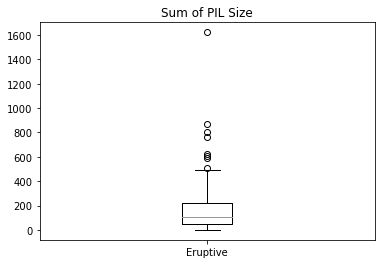

In [16]:
plt.title("Sum of PIL Size")
plt.boxplot(list(er_avg_pil_size_dict.values()))
plt.xticks([1], ["Eruptive"])
plt.show()

#### * Sum of Manetic field strength

In [17]:
er_avg_pil_strength_dict = avg_pil(er_ar_dict,'sum_mag_field_strength')

Repeat HARP (11162, 384)
Repeat HARP (11319, 940)
Repeat HARP (11348, 1028)
Repeat HARP (11402, 1321)
Repeat HARP (11430, 1449)
Repeat HARP (11885, 3321)
Repeat HARP (11944, 3563)
All SPE HARP (12087, 4225)
Repeat HARP (12173, 4580)
Repeat HARP (12345, 5541)
Repeat HARP (12567, 6670)


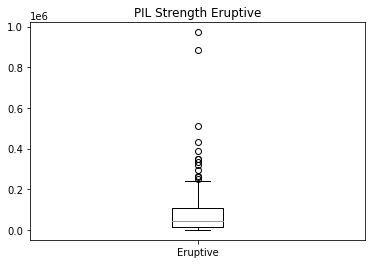

In [18]:
plt.title("PIL Strength Eruptive")
plt.boxplot(list(er_avg_pil_strength_dict.values()))
plt.xticks([1], ["Eruptive"])
plt.show()

##### * PIL Fractal Dimension

In [19]:
er_avg_pil_frac_dim_dict = avg_pil(er_ar_dict,'fra_dim')

Repeat HARP (11162, 384)
Repeat HARP (11319, 940)
Repeat HARP (11348, 1028)
Repeat HARP (11402, 1321)
Repeat HARP (11430, 1449)
Repeat HARP (11885, 3321)
Repeat HARP (11944, 3563)
All SPE HARP (12087, 4225)
Repeat HARP (12173, 4580)
Repeat HARP (12345, 5541)
Repeat HARP (12567, 6670)


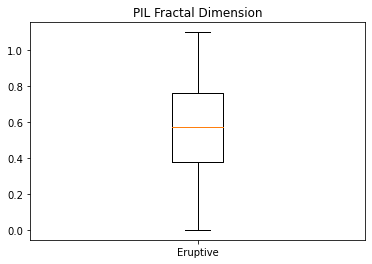

In [20]:
plt.title("PIL Fractal Dimension")
plt.boxplot(list(er_avg_pil_frac_dim_dict.values()))
plt.xticks([1], ["Eruptive"])
plt.show()

In [21]:
#Confirm unique HARP number
len(set([k[1] for k in er_ar_dict.keys()]))

172

## Non Eruptive AR  New list

In [22]:
#Non Flare AR

non_erup_ar_df = read_ar_harp_file('a_h_update_non_eruptive_ar_harp.csv')

In [23]:
non_erup_ar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 87 to 145
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   AR_number     52 non-null     int64 
 1   HARP_num      52 non-null     object
 2   len_harp      52 non-null     int64 
 3   HARP_num_obj  52 non-null     object
dtypes: int64(2), object(2)
memory usage: 2.0+ KB


In [26]:
"""
12736 doesn't have HARP 7350 pil csv file
12740 doesn't have HARP 7357 pil csv file
HARP 7350 and HARP 7357 don't have HARP folder in raw-sharps
"""
non_erup_ar_dict = search_ar_pil_series(non_erup_ar_df,noaa_ar_df)


12736 doesn't have HARP 7350 pil csv file
12740 doesn't have HARP 7357 pil csv file


In [27]:
len(non_erup_ar_dict)

50

#### * Number of PIL

In [28]:
non_erp_ar_avg_dict = avg_pil(non_erup_ar_dict,'num_PILs')

Repeat HARP (11564, 1999)
Repeat HARP (11904, 3376)


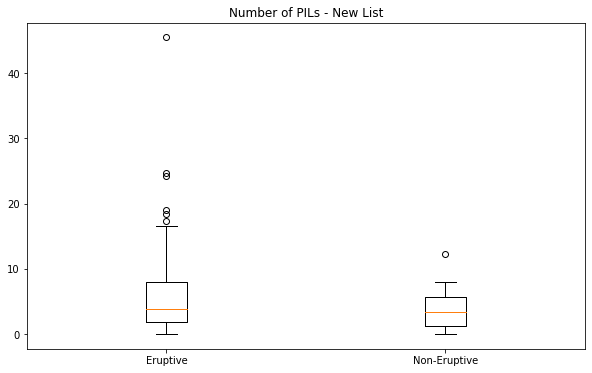

In [29]:
plt.figure(figsize=(10,6))
plt.title("Number of PILs - New List")
plt.boxplot([list(er_avg_dict.values()),list(non_erp_ar_avg_dict.values())])
plt.xticks([1,2], ["Eruptive","Non-Eruptive"])
plt.show()

In [30]:
non_erup_pil_size_ar_avg_dict = avg_pil(non_erup_ar_dict,'sum_PIL_length')

Repeat HARP (11564, 1999)
Repeat HARP (11904, 3376)


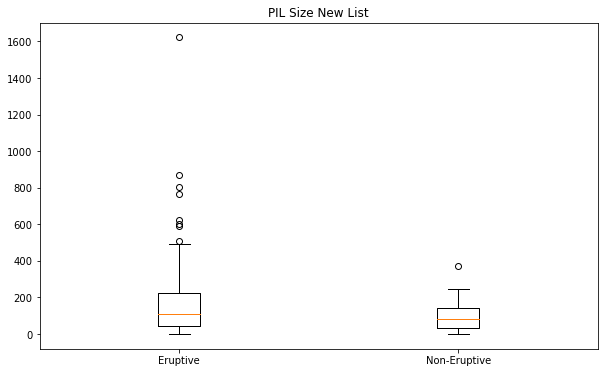

In [31]:
plt.figure(figsize=(10,6))
plt.title("PIL Size New List")
plt.boxplot([list(er_avg_pil_size_dict.values()),list(non_erup_pil_size_ar_avg_dict.values())])
plt.xticks([1,2], ["Eruptive","Non-Eruptive"])
plt.show()

In [32]:
non_erup_pil_stren_ar_avg_dict = avg_pil(non_erup_ar_dict,'sum_mag_field_strength')

Repeat HARP (11564, 1999)
Repeat HARP (11904, 3376)


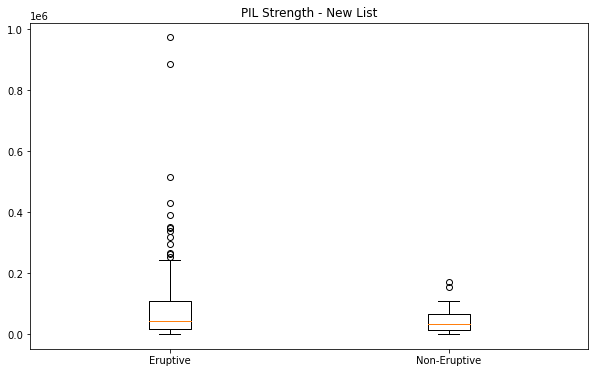

In [33]:
plt.figure(figsize=(10,6))
plt.title("PIL Strength - New List")
plt.boxplot([list(er_avg_pil_strength_dict.values()),list(non_erup_pil_stren_ar_avg_dict.values())])
plt.xticks([1,2], ["Eruptive","Non-Eruptive"])
plt.show()

In [34]:
non_erup_pil_fra_dim_ar_avg_dict = avg_pil(non_erup_ar_dict,'fra_dim')

Repeat HARP (11564, 1999)
Repeat HARP (11904, 3376)


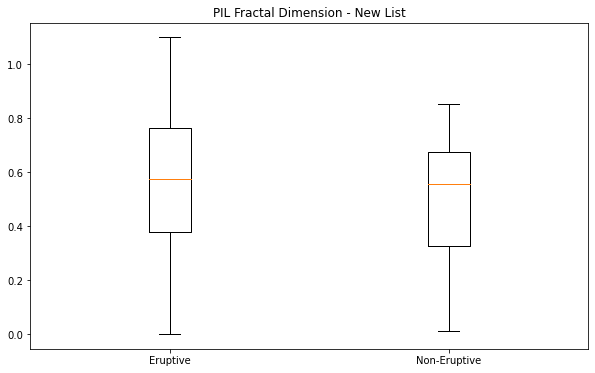

In [35]:
plt.figure(figsize=(10,6))
plt.title("PIL Fractal Dimension - New List")
plt.boxplot([list(er_avg_pil_frac_dim_dict.values()),list(non_erup_pil_fra_dim_ar_avg_dict.values())])
plt.xticks([1,2], ["Eruptive","Non-Eruptive"])
plt.show()

### Eruption Instances - New List

In [36]:

#Pre-Eruption time window selection for Eruptive Active Region
def pre_erup_ar(dic,flare_df,del_time=12):
    
    
    pre_erup_dic = dict()
    
    
    for k,v in dic.items():
        
        
        df = flare_df[flare_df['noaa_active_region']== k[0]].copy()
        
        cond_filter1 = (df['class_level'] == "C") & (df['class_numeric'] >=5.0)
        
        cond_filter2 = df['class_level'].isin(["M","X"])
        
        
        #earliest C.5+ solar flare
        pre_erup_time = min(df[cond_filter1 | cond_filter2]['start_time']) - np.timedelta64(del_time,'h')
        
        pre_erup_df = dic[k].loc[str(pre_erup_time):].copy()#Pre-eruption start time
        
        pre_erup_dic[k] = pre_erup_df
        
    return pre_erup_dic

In [37]:
#Slice window is 24 hours
def search_erup_time(fl_df,pil_df,t_delta=24,cme_conf=3):
    
    
    
    #Given Flare dataframe and PIL dataframe, looking for the PIL time series which 
    #involve eruption (Flare above C5.0 and associate with CME with confidence >=3)
    
    
#     df = flare_df[flare_df['noaa_active_region']== ar_number].copy()
    
    
    #Filter Eruptive Instance
    cond_cme = fl_df['cme_assoc_conf'] >= cme_conf
    
    cond_flare1 = (fl_df['class_level'] == "C") & (fl_df['class_numeric'] >=5.0)
    
    cond_flare2 = fl_df['class_level'].isin(["M","X"])
    
    eruptived_df = fl_df[cond_cme & (cond_flare1 | cond_flare2)]
    
    
    #Slice  hour window
    pre_erup_time = list(eruptived_df['start_time'] - np.timedelta64(t_delta,'h'))
    
    
    erup_time_lst = list(zip(pre_erup_time, list(eruptived_df['start_time'])))
    

    #Searching Eruptived Time PIL records
    
    e_df_lst = []
    
    for t in erup_time_lst:
        
        e_df = pil_df.loc[str(t[0]):str(t[-1])].copy()
        

        
        e_df_lst.append(e_df)
        

        
 

    erp_df = pd.concat(e_df_lst)
    
    erp_df = erp_df[~erp_df.index.duplicated(keep='first')].copy()
    
    return erp_df
    

In [38]:
def search_confined_time(fl_df,pil_df,t_delta=24):
    
    
    
    cond_cme = fl_df['cme_id'].isna()
    
    cond_flare1 = (fl_df['class_level'] == "C") & (fl_df['class_numeric'] >=5.0)
    cond_flare2 = fl_df['class_level'].isin(["M","X"])
    
    confined_fl_df = fl_df[cond_cme & (cond_flare1 | cond_flare2)]
    
    if len(confined_fl_df) >0 :
    
    #Slice 24 hour window
        pre_confined_time = list(confined_fl_df['start_time'] - np.timedelta64(t_delta,'h'))
    
        pre_confined_time_lst = list(zip(pre_confined_time, list(confined_fl_df['start_time'])))
    
        #Searching confined Time PIL records
    
        c_e_df_lst = []
    
        for t in pre_confined_time_lst:
        
            c_e_df = pil_df.loc[str(t[0]):str(t[-1])].copy()
        

        
            c_e_df_lst.append(c_e_df)
        

        
 

        c_erp_df = pd.concat(c_e_df_lst)
    
        c_erp_df = c_erp_df[~c_erp_df.index.duplicated(keep='first')].copy()
    

    
    #if no confined instance will raise error
    return c_erp_df

In [39]:
#Slice window is 24 hours
def search_non_erup_time(fl_df,pil_df,t_delta=24):
    
    #Given Flare dataframe and PIL dataframe, looking for the PIL time series which not invoved eruptive or uncertain
    #events (any flares>=C1.0)
    
    
    
    cond_flare1 = (fl_df['class_level'] == "C") & (fl_df['class_numeric'] >=1.0)
    
    cond_flare2 = fl_df['class_level'].isin(["M","X"])
    
    flare_df = fl_df[(cond_flare1 | cond_flare2)]
    
        #Slice 12 hour window
    pre_window = list(flare_df['start_time'] - np.timedelta64(t_delta,'h'))
    
    
    flare_time_lst = list(zip(pre_window, list(flare_df['start_time'])))
    
    
    #Searching Eruptived Time PIL records
    
    e_df_lst = []
    
    for t in flare_time_lst:
        
        e_df = pil_df.loc[str(t[0]):str(t[-1])].copy()
        

        
        e_df_lst.append(e_df)
        
    
    erp_df_t_index = pd.concat(e_df_lst).index.drop_duplicates(keep='first')
    
    
    
    
    #Non-Eruptive Time
    
    non_erp_df = pil_df[~pil_df.index.isin(erp_df_t_index)].copy()
    
    
    return non_erp_df

In [40]:
#Slice window is 24 hours
def search_erup_instance(dic,flare_df,t_delta=24,cme_conf=3):
    
    erup_dic = dict()
    
    for k,v in dic.items():
        
        
        try:
        
        
            fl_df = flare_df[flare_df['noaa_active_region']== k[0]].copy()

            erp_pil_inst = search_erup_time(fl_df,v,t_delta,cme_conf)

            erup_dic[k] = erp_pil_inst
            
        
        except:
            
            print(k)
        
    
    
    return erup_dic
        

In [41]:
#Slice window is 24 hours
def search_confined_instance(dic,flare_df,t_delta=24):
    
    con_erup_dic = dict()
    
    for k,v in dic.items():
        
        
        try:
        
        
            fl_df = flare_df[flare_df['noaa_active_region']== k[0]].copy()

            con_erp_pil_inst = search_confined_time(fl_df,v,t_delta=24)

            con_erup_dic[k] = con_erp_pil_inst
            
        
        except:
            
            #if raise the error, no confined instance.
            print(k) 
        
    
    
    return con_erup_dic

In [42]:
#Slice window is 24 hours
def search_non_erup_instance(dic,flare_df,t_delta=24):
    
    non_erup_dic = dict()
    
    for k,v in dic.items():
        
        
        try:
            fl_df = flare_df[flare_df['noaa_active_region']== k[0]].copy()
        
            non_erp_pil_inst = search_non_erup_time(fl_df,v,t_delta)
        
            non_erup_dic[k] = non_erp_pil_inst
            
        except:
            print(k)
        
    
    
    return non_erup_dic

In [43]:

def count_eruption_instance(ar_number,flare_df,cme_conf=3):
    
    #By given the acrive region number to calculate the number of eruptive instances.
    
        #Filter Eruptive Instance
    
    
    fl_df = flare_df[flare_df['noaa_active_region']== ar_number].copy()
    
    cond_cme = fl_df['cme_assoc_conf'] >= cme_conf
    
    cond_flare1 = (fl_df['class_level'] == "C") & (fl_df['class_numeric'] >=5.0)
    
    cond_flare2 = fl_df['class_level'].isin(["M","X"])
    
    eruptived_df = fl_df[cond_cme & (cond_flare1 | cond_flare2)]
    
    return eruptived_df,len(eruptived_df)

In [44]:
e_flare_ar = pd.read_csv('/home/xmcai8/fl2cme.csv')

In [45]:
e_flare_ar['noaa_active_region'] = e_flare_ar['noaa_active_region'].apply(lambda x: x+10000 if x<=10000 else x)

In [46]:
e_flare_ar['start_time'] = pd.to_datetime(e_flare_ar['start_time']) 

In [47]:
e_flare_ar['class_level'] = e_flare_ar['goes_class'].apply(lambda x: list(x)[0])
e_flare_ar['class_numeric'] = e_flare_ar['goes_class'].apply(lambda x: float(''.join(list(x)[1:])))

In [48]:
#Eruptive AR instance
erup_ar_ins_dic = search_erup_instance(er_ar_dict,e_flare_ar)

(11069, 8)
(11079, 49)
(11081, 54)
(11112, 211)
(11161, 384)
(11162, 384)
(11195, 514)
(11280, 812)
(11315, 927)
(11343, 1046)
(11346, 1066)
(11380, 1209)
(11389, 1256)
(11401, 1321)
(11434, 1464)
(11466, 1603)
(11471, 1621)
(11540, 1907)
(11542, 1930)
(11583, 2040)
(11675, 2491)
(11686, 2519)
(11817, 3048)
(11869, 3273)
(11928, 3497)
(11934, 3520)
(11943, 3563)
(11973, 3719)
(11982, 3766)
(12082, 4205)
(12093, 4252)
(12160, 4541)
(12178, 4616)
(12182, 4639)
(12191, 4678)
(12197, 4734)
(12209, 4817)
(12333, 5492)
(12565, 6670)
(12671, 7107)


In [49]:
e_flare_ar[e_flare_ar['noaa_active_region'] == 11079]

flare_id          start_time            peak_time             end_time  \
12  gid_sdo_13 2010-06-13 05:30:00  2010-06-13 05:39:00  2010-06-13 05:44:00   

   goes_class  noaa_active_region  fl_lon  fl_lat fl_loc_src ssw_flare_id  \
12       M1.0             11079.0    84.0   -25.0       GOES          NaN   

    ...            candidate_ars  cme_id  fl_pa cme_mpa diff_a  cme_vel  \
12  ...  [11079.0, nan, 11079.0]     NaN    NaN     NaN    NaN      NaN   

    cme_width  cme_assoc_conf  class_level  class_numeric  
12        NaN             NaN            M            1.0  

[1 rows x 23 columns]

In [50]:
len(erup_ar_ins_dic)

142

#### Number of PIL

In [51]:
erup_ar_ins_avg_dict = avg_pil(erup_ar_ins_dic,'num_PILs')

All SPE HARP (11121, 245)
All SPE HARP (11149, 345)
All SPE HARP (11163, 392)
All SPE HARP (11165, 394)
All SPE HARP (11171, 415)
All SPE HARP (11176, 437)
All SPE HARP (11295, 856)
All SPE HARP (11314, 940)
All SPE HARP (11319, 940)
All SPE HARP (11339, 1028)
All SPE HARP (11348, 1028)
Repeat HARP (11430, 1449)
All SPE HARP (11461, 1582)
All SPE HARP (11476, 1638)
All SPE HARP (11532, 1879)
All SPE HARP (11548, 1946)
All SPE HARP (11598, 2137)
All SPE HARP (11611, 2186)
All SPE HARP (11614, 2193)
All SPE HARP (11739, 2716)
All SPE HARP (11745, 2739)
All SPE HARP (11755, 2760)
All SPE HARP (11777, 2878)
All SPE HARP (11778, 2887)
All SPE HARP (11861, 3258)
All SPE HARP (11873, 3288)
All SPE HARP (11884, 3321)
All SPE HARP (11893, 3364)
All SPE HARP (11947, 3587)
All SPE HARP (11990, 3793)
All SPE HARP (12033, 3985)
All SPE HARP (12087, 4225)
All SPE HARP (12106, 4294)
All SPE HARP (12127, 4396)
All SPE HARP (12149, 4477)
All SPE HARP (12151, 4478)
All SPE HARP (12159, 4539)
All SPE HAR

In [52]:
len(erup_ar_ins_avg_dict)

95

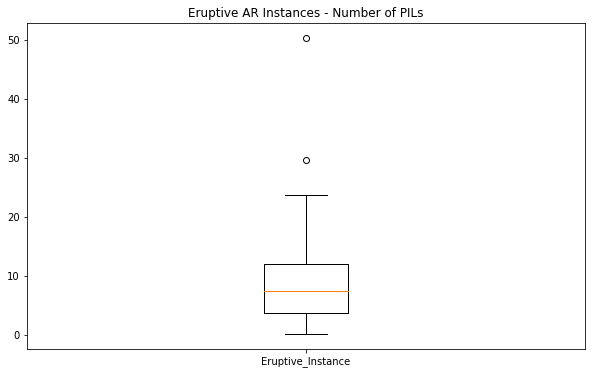

In [53]:
plt.figure(figsize=(10,6))
plt.title("Eruptive AR Instances - Number of PILs")
plt.boxplot([list(erup_ar_ins_avg_dict.values())])
plt.xticks([1], ["Eruptive_Instance"])
plt.show()

In [54]:
erup_ar_ins_avg_pil_size_dict = avg_pil(erup_ar_ins_dic,'sum_PIL_length')

All SPE HARP (11121, 245)
All SPE HARP (11149, 345)
All SPE HARP (11163, 392)
All SPE HARP (11165, 394)
All SPE HARP (11171, 415)
All SPE HARP (11176, 437)
All SPE HARP (11295, 856)
All SPE HARP (11314, 940)
All SPE HARP (11319, 940)
All SPE HARP (11339, 1028)
All SPE HARP (11348, 1028)
Repeat HARP (11430, 1449)
All SPE HARP (11461, 1582)
All SPE HARP (11476, 1638)
All SPE HARP (11532, 1879)
All SPE HARP (11548, 1946)
All SPE HARP (11598, 2137)
All SPE HARP (11611, 2186)
All SPE HARP (11614, 2193)
All SPE HARP (11739, 2716)
All SPE HARP (11745, 2739)
All SPE HARP (11755, 2760)
All SPE HARP (11777, 2878)
All SPE HARP (11778, 2887)
All SPE HARP (11861, 3258)
All SPE HARP (11873, 3288)
All SPE HARP (11884, 3321)
All SPE HARP (11893, 3364)
All SPE HARP (11947, 3587)
All SPE HARP (11990, 3793)
All SPE HARP (12033, 3985)
All SPE HARP (12087, 4225)
All SPE HARP (12106, 4294)
All SPE HARP (12127, 4396)
All SPE HARP (12149, 4477)
All SPE HARP (12151, 4478)
All SPE HARP (12159, 4539)
All SPE HAR

In [55]:
erup_ar_ins_avg_pil_str_dict = avg_pil(erup_ar_ins_dic,'sum_mag_field_strength')

All SPE HARP (11121, 245)
All SPE HARP (11149, 345)
All SPE HARP (11163, 392)
All SPE HARP (11165, 394)
All SPE HARP (11171, 415)
All SPE HARP (11176, 437)
All SPE HARP (11295, 856)
All SPE HARP (11314, 940)
All SPE HARP (11319, 940)
All SPE HARP (11339, 1028)
All SPE HARP (11348, 1028)
Repeat HARP (11430, 1449)
All SPE HARP (11461, 1582)
All SPE HARP (11476, 1638)
All SPE HARP (11532, 1879)
All SPE HARP (11548, 1946)
All SPE HARP (11598, 2137)
All SPE HARP (11611, 2186)
All SPE HARP (11614, 2193)
All SPE HARP (11739, 2716)
All SPE HARP (11745, 2739)
All SPE HARP (11755, 2760)
All SPE HARP (11777, 2878)
All SPE HARP (11778, 2887)
All SPE HARP (11861, 3258)
All SPE HARP (11873, 3288)
All SPE HARP (11884, 3321)
All SPE HARP (11893, 3364)
All SPE HARP (11947, 3587)
All SPE HARP (11990, 3793)
All SPE HARP (12033, 3985)
All SPE HARP (12087, 4225)
All SPE HARP (12106, 4294)
All SPE HARP (12127, 4396)
All SPE HARP (12149, 4477)
All SPE HARP (12151, 4478)
All SPE HARP (12159, 4539)
All SPE HAR

In [56]:
erup_ar_ins_avg_pil_frac_dict = avg_pil(erup_ar_ins_dic,'fra_dim')

All SPE HARP (11121, 245)
All SPE HARP (11149, 345)
All SPE HARP (11163, 392)
All SPE HARP (11165, 394)
All SPE HARP (11171, 415)
All SPE HARP (11176, 437)
All SPE HARP (11295, 856)
All SPE HARP (11314, 940)
All SPE HARP (11319, 940)
All SPE HARP (11339, 1028)
All SPE HARP (11348, 1028)
Repeat HARP (11430, 1449)
All SPE HARP (11461, 1582)
All SPE HARP (11476, 1638)
All SPE HARP (11532, 1879)
All SPE HARP (11548, 1946)
All SPE HARP (11598, 2137)
All SPE HARP (11611, 2186)
All SPE HARP (11614, 2193)
All SPE HARP (11739, 2716)
All SPE HARP (11745, 2739)
All SPE HARP (11755, 2760)
All SPE HARP (11777, 2878)
All SPE HARP (11778, 2887)
All SPE HARP (11861, 3258)
All SPE HARP (11873, 3288)
All SPE HARP (11884, 3321)
All SPE HARP (11893, 3364)
All SPE HARP (11947, 3587)
All SPE HARP (11990, 3793)
All SPE HARP (12033, 3985)
All SPE HARP (12087, 4225)
All SPE HARP (12106, 4294)
All SPE HARP (12127, 4396)
All SPE HARP (12149, 4477)
All SPE HARP (12151, 4478)
All SPE HARP (12159, 4539)
All SPE HAR

### Confined AR instance

In [57]:
con_ar_ins_dic = search_confined_instance(er_ar_dict,e_flare_ar,t_delta=24)

(11093, 115)
(11149, 345)
(11163, 392)
(11280, 812)
(11314, 940)
(11315, 927)
(11343, 1046)
(11380, 1209)
(11384, 1221)
(11430, 1449)
(11461, 1582)
(11463, 1558)
(11494, 1724)
(11496, 1722)
(11548, 1946)
(11611, 2186)
(11614, 2193)
(11692, 2546)
(11755, 2760)
(11760, 2809)
(11777, 2878)
(11818, 3056)
(11836, 3129)
(11869, 3273)
(11873, 3288)
(11885, 3321)
(11943, 3563)
(11973, 3719)
(11976, 3730)
(11977, 3740)
(12011, 3877)
(12027, 3941)
(12033, 3985)
(12082, 4205)
(12113, 4344)
(12127, 4396)
(12151, 4478)
(12159, 4539)
(12160, 4541)
(12175, 4591)
(12178, 4616)
(12191, 4678)
(12197, 4734)
(12282, 5186)
(12333, 5492)
(12345, 5541)
(12365, 5653)
(12449, 6078)
(12564, 6666)
(12685, 7169)


In [58]:
len(con_ar_ins_dic)

132

In [59]:
con_ar_ins_avg_dict = avg_pil(con_ar_ins_dic,'num_PILs')

All SPE HARP (11079, 49)
All SPE HARP (11121, 245)
Repeat HARP (11162, 384)
All SPE HARP (11171, 415)
All SPE HARP (11195, 514)
All SPE HARP (11226, 637)
All SPE HARP (11348, 1028)
All SPE HARP (11402, 1321)
All SPE HARP (11532, 1879)
All SPE HARP (11583, 2040)
All SPE HARP (11598, 2137)
All SPE HARP (11613, 2191)
All SPE HARP (11719, 2635)
All SPE HARP (11726, 2673)
All SPE HARP (11745, 2739)
All SPE HARP (11787, 2920)
All SPE HARP (11947, 3587)
All SPE HARP (11990, 3793)
All SPE HARP (12010, 3856)
All SPE HARP (12014, 3879)
All SPE HARP (12085, 4197)
All SPE HARP (12087, 4225)
All SPE HARP (12106, 4294)
All SPE HARP (12158, 4536)
Repeat HARP (12173, 4580)
All SPE HARP (12290, 5233)
All SPE HARP (12321, 5447)
All SPE HARP (12420, 5974)
All SPE HARP (12423, 5982)
Repeat HARP (12567, 6670)


In [60]:
len(con_ar_ins_avg_dict)

102

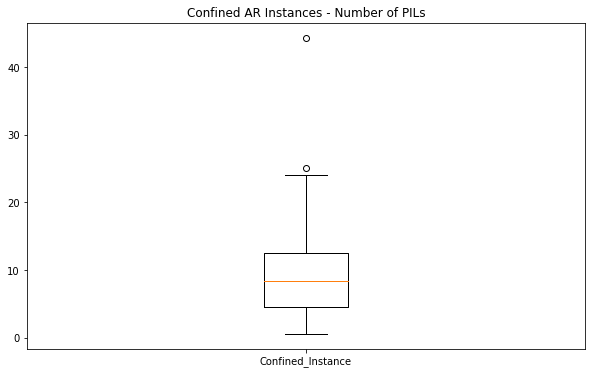

In [61]:
plt.figure(figsize=(10,6))
plt.title("Confined AR Instances - Number of PILs")
plt.boxplot([list(con_ar_ins_avg_dict.values())])
plt.xticks([1], ["Confined_Instance"])
plt.show()

In [62]:
con_ar_ins_avg_pil_size_dict = avg_pil(con_ar_ins_dic,'sum_PIL_length')

All SPE HARP (11079, 49)
All SPE HARP (11121, 245)
Repeat HARP (11162, 384)
All SPE HARP (11171, 415)
All SPE HARP (11195, 514)
All SPE HARP (11226, 637)
All SPE HARP (11348, 1028)
All SPE HARP (11402, 1321)
All SPE HARP (11532, 1879)
All SPE HARP (11583, 2040)
All SPE HARP (11598, 2137)
All SPE HARP (11613, 2191)
All SPE HARP (11719, 2635)
All SPE HARP (11726, 2673)
All SPE HARP (11745, 2739)
All SPE HARP (11787, 2920)
All SPE HARP (11947, 3587)
All SPE HARP (11990, 3793)
All SPE HARP (12010, 3856)
All SPE HARP (12014, 3879)
All SPE HARP (12085, 4197)
All SPE HARP (12087, 4225)
All SPE HARP (12106, 4294)
All SPE HARP (12158, 4536)
Repeat HARP (12173, 4580)
All SPE HARP (12290, 5233)
All SPE HARP (12321, 5447)
All SPE HARP (12420, 5974)
All SPE HARP (12423, 5982)
Repeat HARP (12567, 6670)


In [63]:
con_ar_ins_avg_pil_str_dict = avg_pil(con_ar_ins_dic,'sum_mag_field_strength')

All SPE HARP (11079, 49)
All SPE HARP (11121, 245)
Repeat HARP (11162, 384)
All SPE HARP (11171, 415)
All SPE HARP (11195, 514)
All SPE HARP (11226, 637)
All SPE HARP (11348, 1028)
All SPE HARP (11402, 1321)
All SPE HARP (11532, 1879)
All SPE HARP (11583, 2040)
All SPE HARP (11598, 2137)
All SPE HARP (11613, 2191)
All SPE HARP (11719, 2635)
All SPE HARP (11726, 2673)
All SPE HARP (11745, 2739)
All SPE HARP (11787, 2920)
All SPE HARP (11947, 3587)
All SPE HARP (11990, 3793)
All SPE HARP (12010, 3856)
All SPE HARP (12014, 3879)
All SPE HARP (12085, 4197)
All SPE HARP (12087, 4225)
All SPE HARP (12106, 4294)
All SPE HARP (12158, 4536)
Repeat HARP (12173, 4580)
All SPE HARP (12290, 5233)
All SPE HARP (12321, 5447)
All SPE HARP (12420, 5974)
All SPE HARP (12423, 5982)
Repeat HARP (12567, 6670)


In [64]:
con_ar_ins_avg_pil_frac_dict = avg_pil(con_ar_ins_dic,'fra_dim')

All SPE HARP (11079, 49)
All SPE HARP (11121, 245)
Repeat HARP (11162, 384)
All SPE HARP (11171, 415)
All SPE HARP (11195, 514)
All SPE HARP (11226, 637)
All SPE HARP (11348, 1028)
All SPE HARP (11402, 1321)
All SPE HARP (11532, 1879)
All SPE HARP (11583, 2040)
All SPE HARP (11598, 2137)
All SPE HARP (11613, 2191)
All SPE HARP (11719, 2635)
All SPE HARP (11726, 2673)
All SPE HARP (11745, 2739)
All SPE HARP (11787, 2920)
All SPE HARP (11947, 3587)
All SPE HARP (11990, 3793)
All SPE HARP (12010, 3856)
All SPE HARP (12014, 3879)
All SPE HARP (12085, 4197)
All SPE HARP (12087, 4225)
All SPE HARP (12106, 4294)
All SPE HARP (12158, 4536)
Repeat HARP (12173, 4580)
All SPE HARP (12290, 5233)
All SPE HARP (12321, 5447)
All SPE HARP (12420, 5974)
All SPE HARP (12423, 5982)
Repeat HARP (12567, 6670)


### Non Eruptive AR Instance

In [65]:
#Eruptive AR: Non eruptive instance1
non_erup_ar_ins_dic_1 = search_non_erup_instance(er_ar_dict,e_flare_ar)

(11280, 812)
(11315, 927)
(11343, 1046)
(11380, 1209)
(11943, 3563)
(12160, 4541)
(12191, 4678)
(12197, 4734)


In [66]:
len(non_erup_ar_ins_dic_1)

174

In [67]:
non_ar_ins_avg_dict_1 = avg_pil(non_erup_ar_ins_dic_1,'num_PILs')

All SPE HARP (11081, 54)
Repeat HARP (11162, 384)
All SPE HARP (11302, 892)
All SPE HARP (11303, 899)
Repeat HARP (11319, 940)
Repeat HARP (11348, 1028)
Repeat HARP (11402, 1321)
Repeat HARP (11430, 1449)
All SPE HARP (11476, 1638)
All SPE HARP (11726, 2673)
Repeat HARP (11885, 3321)
All SPE HARP (11967, 3686)
All SPE HARP (12087, 4225)
Repeat HARP (12173, 4580)
All SPE HARP (12192, 4698)
All SPE HARP (12242, 4920)
All SPE HARP (12297, 5298)
All SPE HARP (12339, 5541)
All SPE HARP (12371, 5692)
All SPE HARP (12403, 5885)
Repeat HARP (12567, 6670)


In [68]:
non_ar_ins_avg_pil_size_dict_1 = avg_pil(non_erup_ar_ins_dic_1,'sum_PIL_length')

All SPE HARP (11081, 54)
Repeat HARP (11162, 384)
All SPE HARP (11302, 892)
All SPE HARP (11303, 899)
Repeat HARP (11319, 940)
Repeat HARP (11348, 1028)
Repeat HARP (11402, 1321)
Repeat HARP (11430, 1449)
All SPE HARP (11476, 1638)
All SPE HARP (11726, 2673)
Repeat HARP (11885, 3321)
All SPE HARP (11967, 3686)
All SPE HARP (12087, 4225)
Repeat HARP (12173, 4580)
All SPE HARP (12192, 4698)
All SPE HARP (12242, 4920)
All SPE HARP (12297, 5298)
All SPE HARP (12339, 5541)
All SPE HARP (12371, 5692)
All SPE HARP (12403, 5885)
Repeat HARP (12567, 6670)


In [69]:
non_ar_ins_avg_pil_str_dict_1 = avg_pil(non_erup_ar_ins_dic_1,'sum_mag_field_strength')

All SPE HARP (11081, 54)
Repeat HARP (11162, 384)
All SPE HARP (11302, 892)
All SPE HARP (11303, 899)
Repeat HARP (11319, 940)
Repeat HARP (11348, 1028)
Repeat HARP (11402, 1321)
Repeat HARP (11430, 1449)
All SPE HARP (11476, 1638)
All SPE HARP (11726, 2673)
Repeat HARP (11885, 3321)
All SPE HARP (11967, 3686)
All SPE HARP (12087, 4225)
Repeat HARP (12173, 4580)
All SPE HARP (12192, 4698)
All SPE HARP (12242, 4920)
All SPE HARP (12297, 5298)
All SPE HARP (12339, 5541)
All SPE HARP (12371, 5692)
All SPE HARP (12403, 5885)
Repeat HARP (12567, 6670)


In [70]:
non_ar_ins_avg_pil_frac_dict_1 = avg_pil(non_erup_ar_ins_dic_1,'fra_dim')

All SPE HARP (11081, 54)
Repeat HARP (11162, 384)
All SPE HARP (11302, 892)
All SPE HARP (11303, 899)
Repeat HARP (11319, 940)
Repeat HARP (11348, 1028)
Repeat HARP (11402, 1321)
Repeat HARP (11430, 1449)
All SPE HARP (11476, 1638)
All SPE HARP (11726, 2673)
Repeat HARP (11885, 3321)
All SPE HARP (11967, 3686)
All SPE HARP (12087, 4225)
Repeat HARP (12173, 4580)
All SPE HARP (12192, 4698)
All SPE HARP (12242, 4920)
All SPE HARP (12297, 5298)
All SPE HARP (12339, 5541)
All SPE HARP (12371, 5692)
All SPE HARP (12403, 5885)
Repeat HARP (12567, 6670)


In [ ]:
#Non Eruptive AR: non eruptive instance2

In [71]:
non_erup_ar_ins_dic_2 = search_non_erup_instance(non_erup_ar_dict,e_flare_ar)

(12304, 5345)
(12733, 7334)


In [72]:
non_ar_ins_avg_dict_2 = avg_pil(non_erup_ar_ins_dic_2,'num_PILs')

Repeat HARP (11564, 1999)
Repeat HARP (11904, 3376)
All SPE HARP (12222, 4874)
All SPE HARP (12268, 5107)


In [73]:
non_ar_ins_avg_pil_size_dict_2 = avg_pil(non_erup_ar_ins_dic_2,'sum_PIL_length')

Repeat HARP (11564, 1999)
Repeat HARP (11904, 3376)
All SPE HARP (12222, 4874)
All SPE HARP (12268, 5107)


In [74]:
non_ar_ins_avg_pil_str_dict_2 = avg_pil(non_erup_ar_ins_dic_2,'sum_mag_field_strength')

Repeat HARP (11564, 1999)
Repeat HARP (11904, 3376)
All SPE HARP (12222, 4874)
All SPE HARP (12268, 5107)


In [75]:
non_ar_ins_avg_pil_frac_dict_2 = avg_pil(non_erup_ar_ins_dic_2,'fra_dim')

Repeat HARP (11564, 1999)
Repeat HARP (11904, 3376)
All SPE HARP (12222, 4874)
All SPE HARP (12268, 5107)


In [77]:
def dict_Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [78]:
non_ins_pil_number = dict_Merge (non_ar_ins_avg_dict_1,non_ar_ins_avg_dict_2)

In [79]:
len(non_ar_ins_avg_dict_1)

153

In [80]:
len(non_ar_ins_avg_dict_2)

44

In [81]:
len(non_ins_pil_number)

197

In [82]:
non_ins_pil_size = dict_Merge (non_ar_ins_avg_pil_size_dict_1,non_ar_ins_avg_pil_size_dict_2)

In [83]:
non_ins_pil_str = dict_Merge (non_ar_ins_avg_pil_str_dict_1,non_ar_ins_avg_pil_str_dict_2)

In [84]:
non_ins_pil_frac = dict_Merge (non_ar_ins_avg_pil_frac_dict_1,non_ar_ins_avg_pil_frac_dict_2)

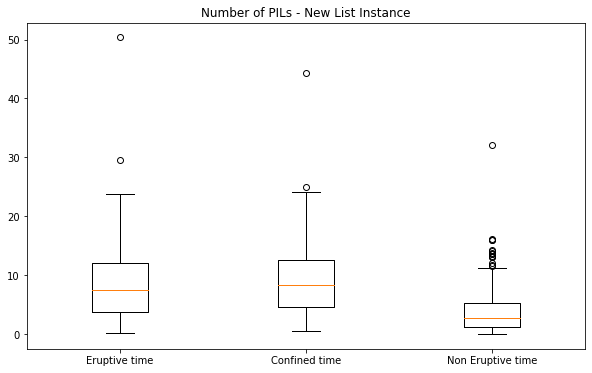

In [85]:
plt.figure(figsize=(10,6))
plt.title("Number of PILs - New List Instance")
plt.boxplot([list(erup_ar_ins_avg_dict.values()),list(con_ar_ins_avg_dict.values()),
             list(non_ins_pil_number.values())])
plt.xticks([1,2,3], ["Eruptive time","Confined time","Non Eruptive time"])
plt.show()

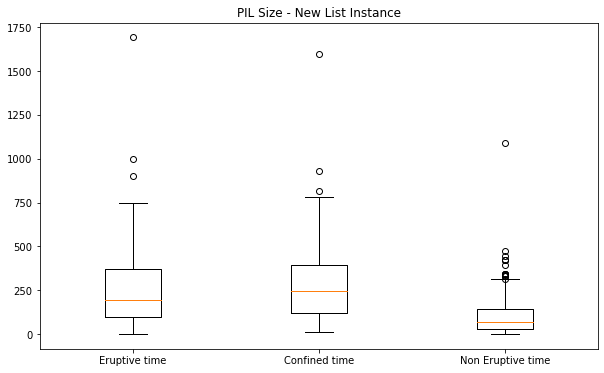

In [86]:
plt.figure(figsize=(10,6))
plt.title("PIL Size - New List Instance")
plt.boxplot([list(erup_ar_ins_avg_pil_size_dict.values()),list(con_ar_ins_avg_pil_size_dict.values()),
             list(non_ins_pil_size.values())])
plt.xticks([1,2,3], ["Eruptive time","Confined time","Non Eruptive time"])
plt.show()

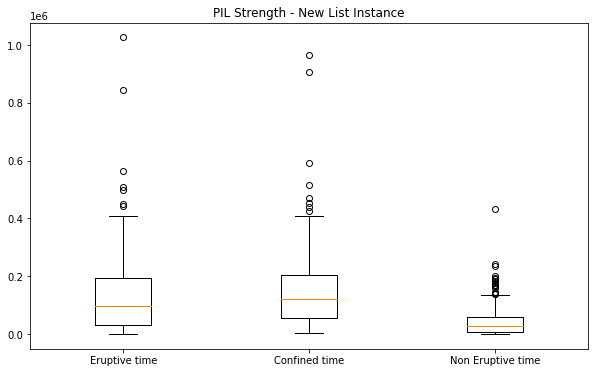

In [87]:
plt.figure(figsize=(10,6))
plt.title("PIL Strength - New List Instance")
plt.boxplot([list(erup_ar_ins_avg_pil_str_dict.values()),list(con_ar_ins_avg_pil_str_dict.values()),
             list(non_ins_pil_str.values())])
plt.xticks([1,2,3], ["Eruptive time","Confined time","Non Eruptive time"])
plt.show()

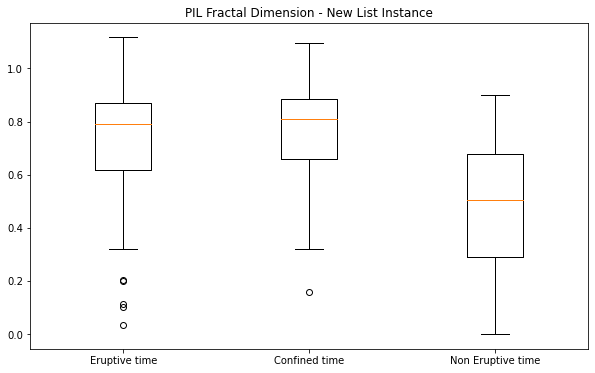

In [88]:
plt.figure(figsize=(10,6))
plt.title("PIL Fractal Dimension - New List Instance")
plt.boxplot([list(erup_ar_ins_avg_pil_frac_dict.values()),list(con_ar_ins_avg_pil_frac_dict.values()),
             list(non_ins_pil_frac.values())])
plt.xticks([1,2,3], ["Eruptive time","Confined time","Non Eruptive time"])
plt.show()

In [185]:
a_non_erup_AR = pd.read_csv('/home/xmcai8/Server_PIL_notebook/nonEruptive_ARs_MARK.csv')
a_non_erup_AR['NOAA']=a_non_erup_AR['NOAA'].astype(int)

In [192]:
len(e_flare_ar[e_flare_ar['noaa_active_region'].isin(a_non_erup_AR['NOAA'])]['noaa_active_region'].unique())

55

In [194]:
a_erup_AR = pd.read_csv('/home/xmcai8/Server_PIL_notebook/Eruptive_ARs_MARK.csv')
a_erup_AR['NOAA']=a_erup_AR['NOAA'].astype(int)